# Geospatial Analysis of a Custom Map

This notebook provides a comprehensive walkthrough for performing geospatial analysis on a custom map.
The ultimate goal is to detect the border of an island and export it as a GeoJSON file. The border was drawn in red (`images/map_border.jpg`) and is detected and converted into a GeoJSON representation for use in Leaflet.Js.

The purpose of this notebook is to give you an example of how to work with images in the form of a custom map. See `index.html` for displaying the map in a webview.

## Table of Contents

1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
3. [Load the Map Image](#Load-the-Map-Image)
4. [Image Preprocessing](#Image-Preprocessing)
5. [Detect the Island Border](#Detect-the-Island-Border)
6. [Export as GeoJSON](#Export-as-GeoJSON)
7. [Conclusion](#Conclusion)


## Prerequisites

Before proceeding, ensure the following Python libraries are installed:

- matplotlib: For plotting and visualization
- numpy: For numerical operations
- PIL (Pillow): For image manipulation
- OpenCV (cv2): For image processing
- shapely: For geometric operations
- geopandas: For geospatial data manipulation


In [ ]:
# Install the required libraries from a requirements.txt file (if you have one)
# !pip install -r requirements.txt

## Image Preprocessing

Before we can detect the island's border, the image needs to be preprocessed.
This involves converting it to a suitable format and applying certain filters to make the border detection more accurate.


<module 'matplotlib.pyplot' from '/Users/shelfwood/Projects/prj-westworld-map/python-environment/lib/python3.11/site-packages/matplotlib/pyplot.py'>

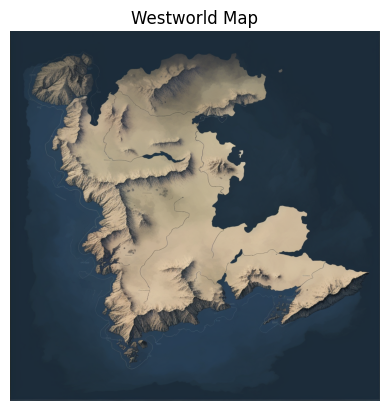

In [54]:

# Import required libraries
from PIL import Image
import matplotlib.pyplot as plt

# Path to the map image (you can adjust this path based on your project structure)
image_path = "images/map.png"

# Load the image
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title("Westworld Map")
plt


## Detect the Island Border

We will use image processing techniques to detect the island's border accurately.
This is an essential step before exporting the border as a GeoJSON file. The border was drawn over the map using an Ipad.


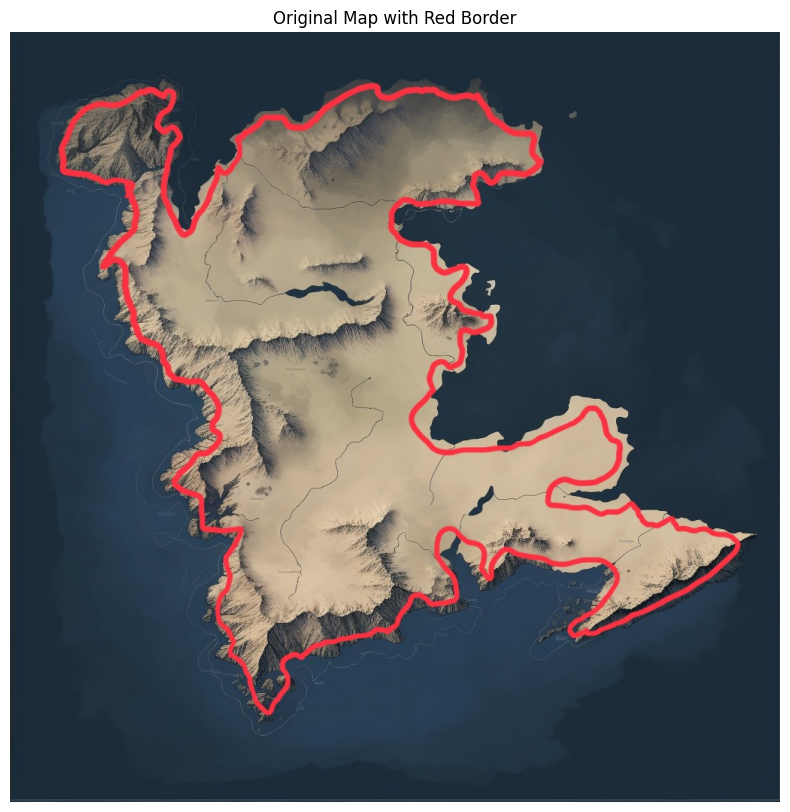

In [55]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image where the island's border is drawn in red
border_image_path = 'images/map_border.jpg'
border_image = Image.open(border_image_path)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(border_image)
plt.title('Original Map with Red Border')
plt.axis('off')
plt.show()


Now that we've displayed the map with the drawn border around it we will detect the border by scanning for red pixels. We'll identify the correct strategy to use.

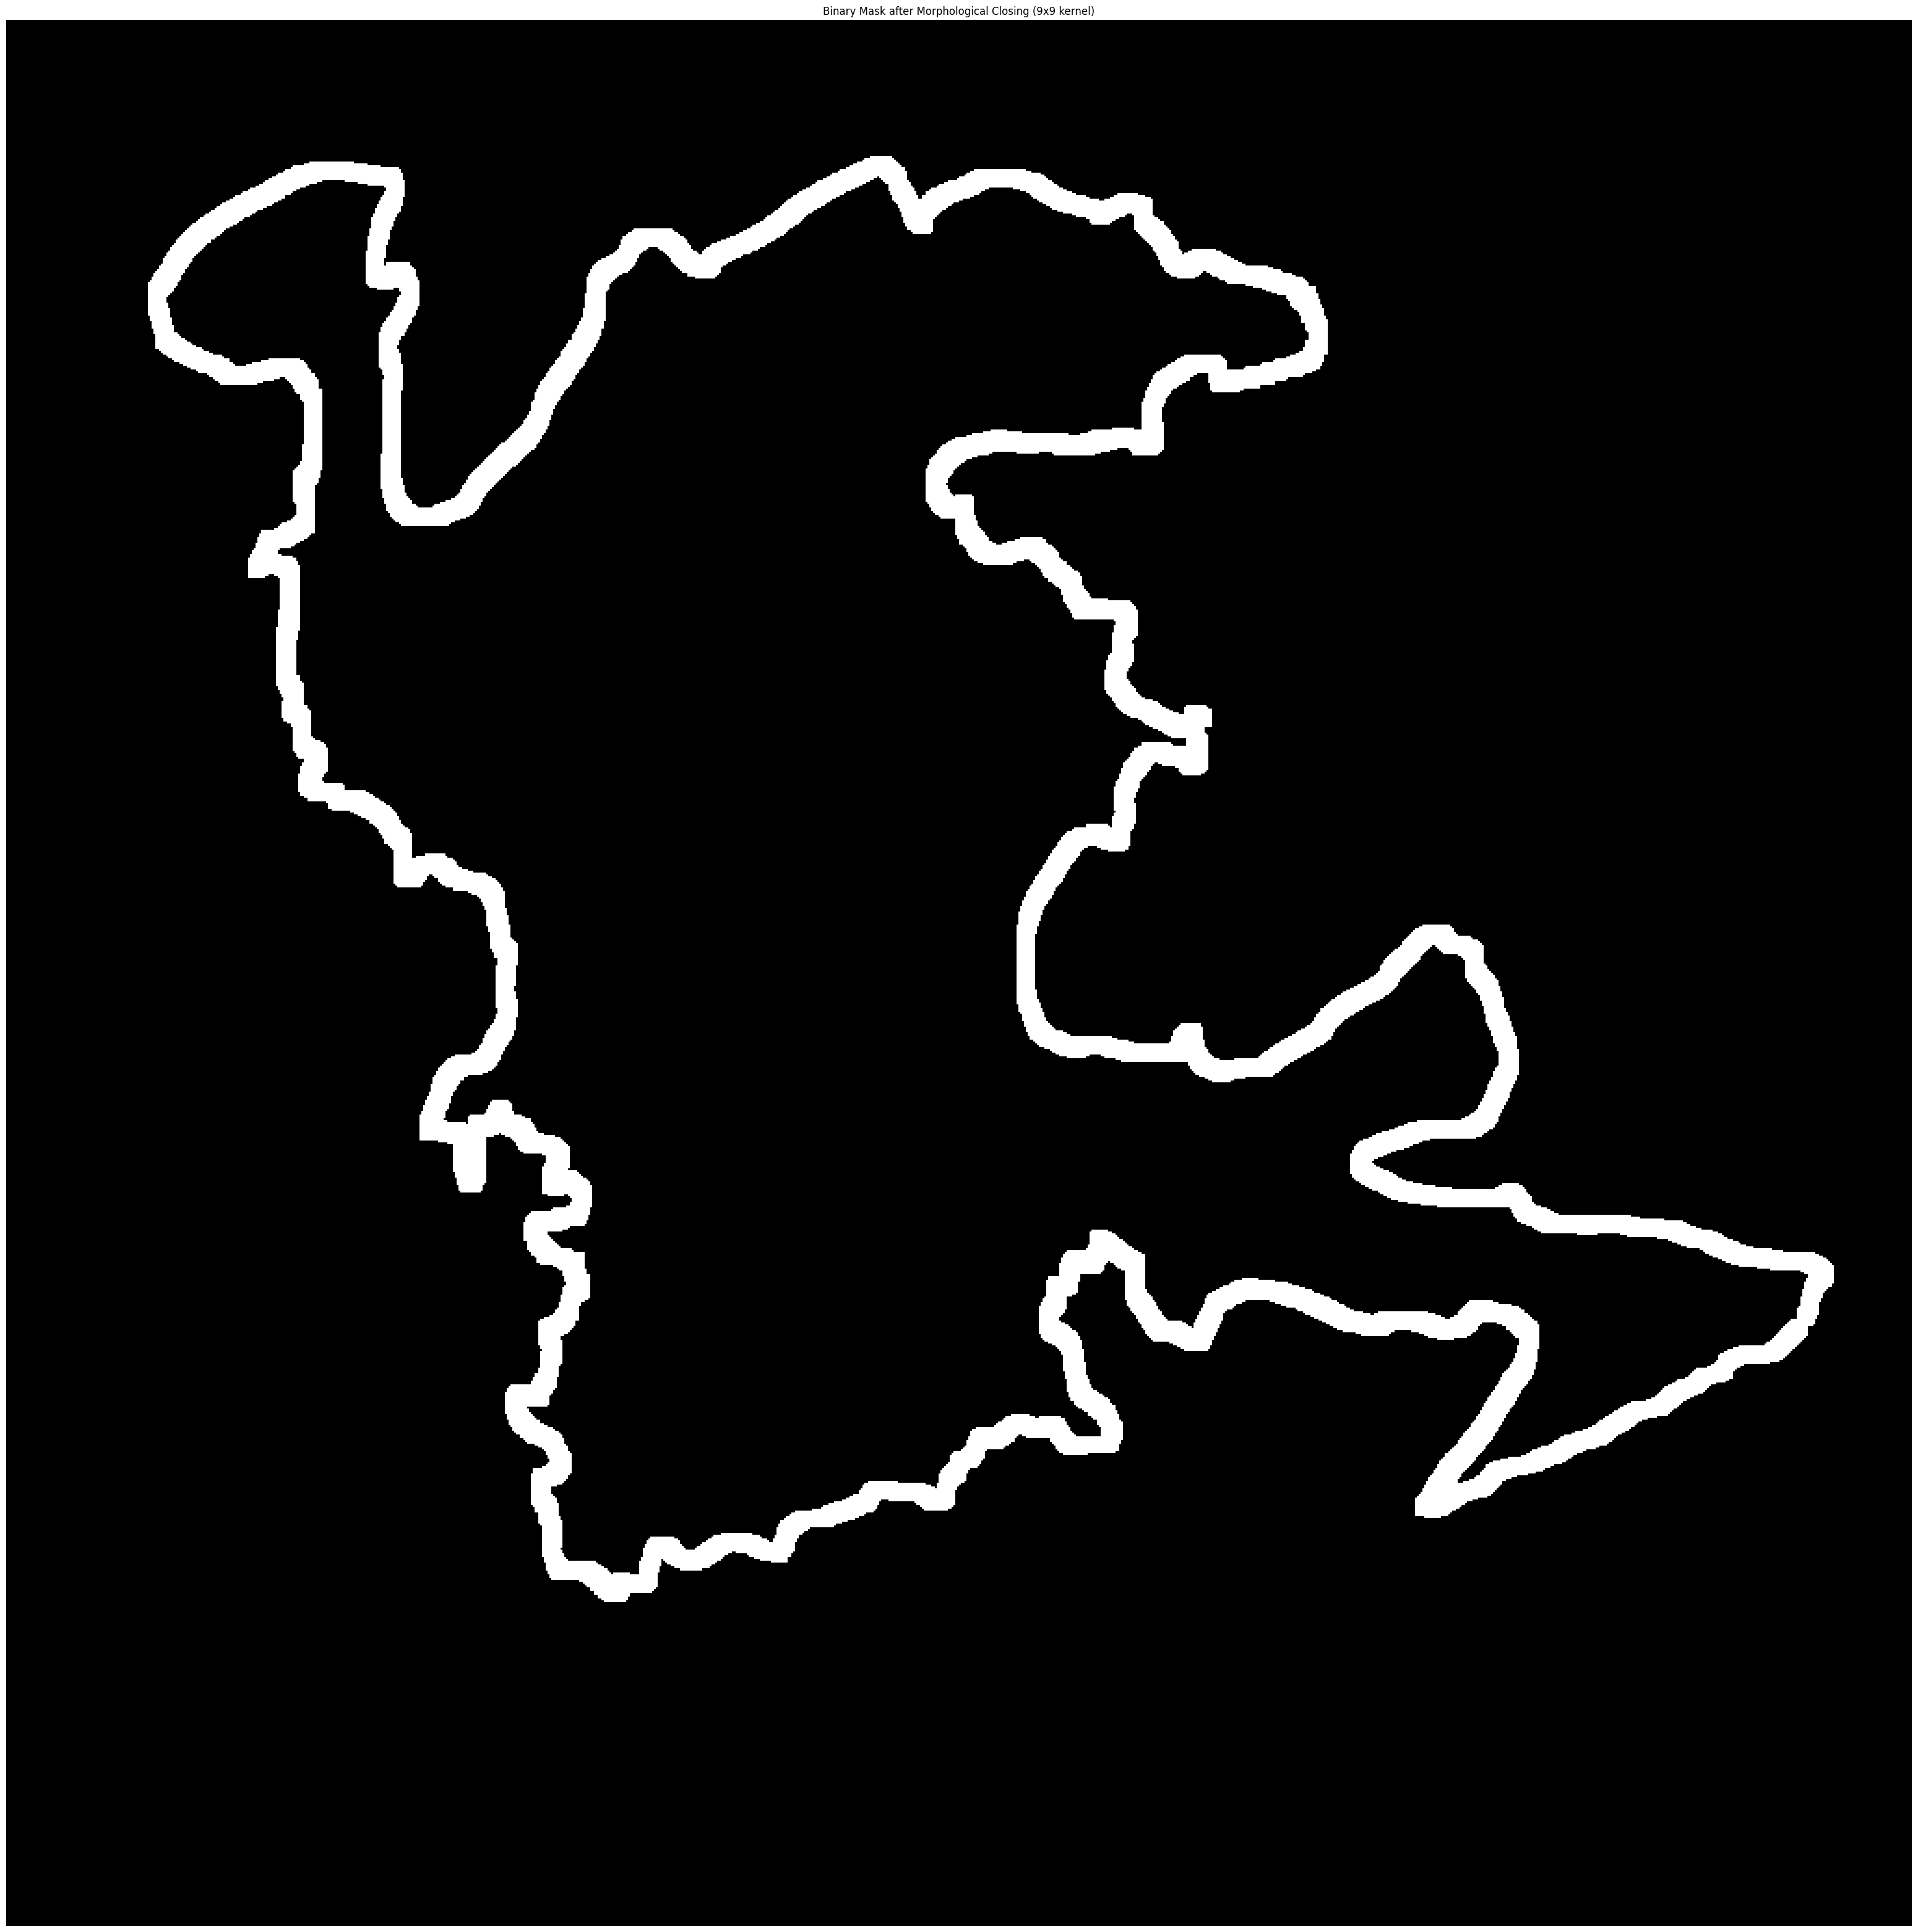

In [64]:
# Function to overlay a binary mask (detected border) on the original map for visualization
def overlay_mask_on_map(binary_mask, original_map):
    overlay = original_map.copy()
    overlay[binary_mask] = [0, 255, 0]  # Replace with green for visualization
    return overlay

# Initial binary mask based on red color detection (before any cv2 operations)
initial_overlay = overlay_mask_on_map(red_mask, border_image_array)

kernel_9x9 = np.ones((9,9), np.uint8)
closing_mask_9x9 = cv2.morphologyEx(red_mask.astype(np.uint8), cv2.MORPH_GRADIENT, kernel_9x9)
closing_overlay_9x9 = overlay_mask_on_map(closing_mask_9x9, border_image_array)

# 1. Plot only the 9x9 binary mask example
plt.figure(figsize=(40, 40))
plt.imshow(closing_mask_9x9, cmap='gray')
plt.title('Binary Mask after Morphological Closing (9x9 kernel)')
plt.axis('off')
plt.show()



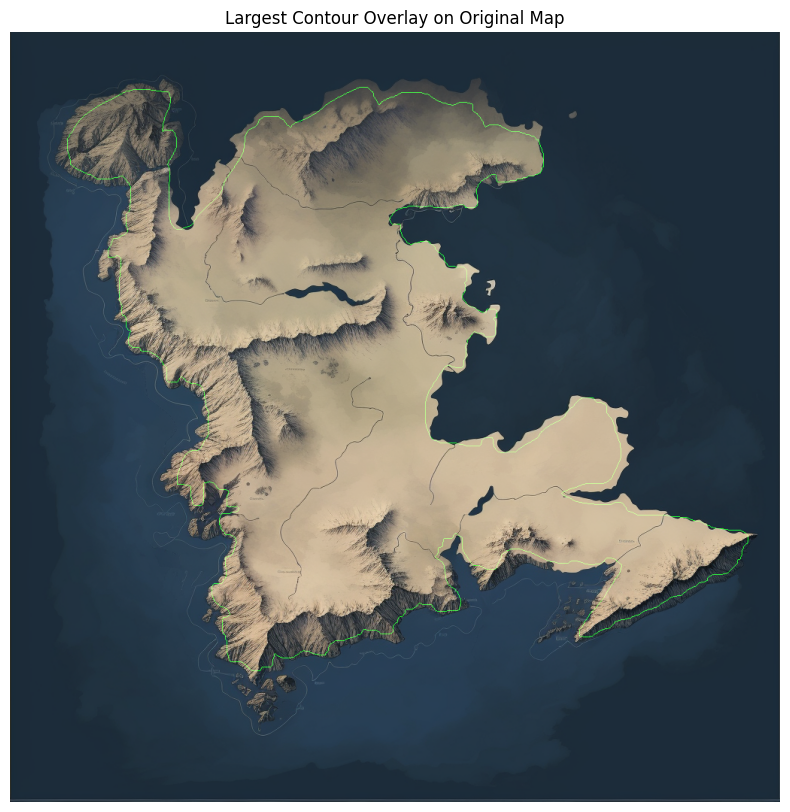

In [67]:
# Find contours in the thicker binary mask (9x9 kernel with MORPH_GRADIENT applied)
contours, _ = cv2.findContours(closing_mask_9x9, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours by area and select the largest one
largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

# Create a Shapely Polygon from the largest contour
outermost_polygon = Polygon(largest_contour.squeeze())

# Create a black image to draw the largest contour
contour_image = np.zeros_like(original_map_array)

# Draw the largest contour in green
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 1)

# Overlay the largest contour on the original map
overlay_contour_on_map = cv2.addWeighted(original_map_array, 1, contour_image, 1, 0)

# Plot the overlay
plt.figure(figsize=(10, 10))
plt.imshow(overlay_contour_on_map)
plt.title('Largest Contour Overlay on Original Map')
plt.axis('off')
plt.show()


## Export as GeoJSON

After detecting the island's border, the next step is to export it as a GeoJSON file.
This GeoJSON file can be easily imported into GIS software or displayed on web maps.


In [78]:
import json
import geopandas as gpd

# Function to flip and scale the coordinates of a GeoJSON object
def flip_and_scale_geojson_coordinates(geojson_data):
    for feature in geojson_data['features']:
        coordinates = feature['geometry']['coordinates'][0]  # Assuming it's a Polygon
        for i in range(len(coordinates)):
            x, y = coordinates[i]
            # Flip the y-coordinate and scale both x and y coordinates
            coordinates[i] = [2048 - y * 2, (x * 2)]

# Create a GeoDataFrame from the Shapely Polygon object representing the largest contour
gdf_outermost = gpd.GeoDataFrame(geometry=[outermost_polygon], crs="EPSG:4326")
geojson_data_outermost = json.loads(gdf_outermost.to_json())

# Modify the coordinates in-place
flip_and_scale_geojson_coordinates(geojson_data_outermost)

# Save the modified GeoJSON data to a file
with open('objects/island.json', 'w') as f:
    json.dump(geojson_data_outermost, f)

# Displaying the first few records of the modified GeoJSON data to verify the transformation
geojson_data_outermost['features'][0]['geometry']['coordinates'][0][:10]


[[1902.0, 928.0],
 [1900.0, 926.0],
 [1900.0, 922.0],
 [1896.0, 918.0],
 [1896.0, 914.0],
 [1894.0, 912.0],
 [1894.0, 910.0],
 [1892.0, 908.0],
 [1892.0, 906.0],
 [1890.0, 904.0]]

## Conclusion

This notebook provided a step-by-step guide for performing geospatial analysis on a custom map.
We successfully detected the island's border and exported it as a GeoJSON file.
